In [ ]:
import sys
import json
import time
import os
import argparse
import gc
import random
from torch.nn.utils import prune

from tensorflow.keras import losses, metrics, optimizers

import numpy as np
import torch, torchvision
import torch.optim as optim

import data_utils
import neural_nets
import distributed_training_utils as dst
from distributed_training_utils import Client, Server
import experiment_manager as xpm
import default_hyperparameters as dhp

import copy
import easydict
import warnings
warnings.filterwarnings('ignore')
#parser = argparse.ArgumentParser()
#parser.add_argument("--schedule", default="main", type=str)
#parser.add_argument("--start", default=0, type=int)
#parser.add_argument("--end", default=None, type=int)
#parser.add_argument("--reverse_order", default=False, type=bool)
args = easydict.EasyDict({
    "schedule": 'main',
    "start": 0,
    "end": None,
    'reverse_order': False,
})

print("Torch Version: ", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#args = parser.parse_args()

# Load the Hyperparameters of all Experiments to be performed and set up the Experiments
with open('federated_learning.json') as data_file:    
  experiments_raw = json.load(data_file)[args.schedule]

hp_dicts = [hp for x in experiments_raw for hp in xpm.get_all_hp_combinations(x)][args.start:args.end]
if args.reverse_order:
  hp_dicts = hp_dicts[::-1]
experiments = [xpm.Experiment(hyperparameters=hp) for hp in hp_dicts]

def weight(experiments, client, hp,f,tempo):
  start_time = time.time()
  client.compress_weight_update_up(compression=hp['compression_up'], accumulate=hp['accumulation_up'], count_bits=hp["count_bits"])
  end_time = time.time()
  #print("--- %s seconds ---" % (end_time - start_time))
  f.write(str(tempo)+" --- %s seconds ---\n" % (end_time - start_time))    

def run_experiments(experiments):
  print("Running {} Experiments..\n".format(len(experiments)))
  for xp_count, xp in enumerate(experiments):
    f= open("compress.txt","w+")
    tempo = 0
    import gc
    gc.collect()
    hp = dhp.get_hp(xp.hyperparameters)
    hp['count_bits'] = True
    xp.prepare(hp)
    #print(xp)

    # Load the Data and split it among the Clients
    #print(hp)
    client_loaders, train_loader, test_loader, stats = data_utils.get_data_loaders(hp)
    # Instantiate Clients and Server with Neural Net
    net = getattr(neural_nets, hp['net'])
    clients = [Client(loader, net().to(device), hp, xp, id_num=i) for i, loader in enumerate(client_loaders)]
    server = Server(test_loader, net().to(device), hp, xp, stats)

    # Print optimizer specs
    print_model(device=clients[0])
    print_optimizer(device=clients[0])

    # Start Distributed Training Process
    print("Start Distributed Training..\n")
    t1 = time.time()

    for c_round in range(1, hp['communication_rounds']+1):
      
      tempo += 1

      participating_clients = random.sample(clients, int(len(clients)*hp['participation_rate'])) 

      # Clients do
      for client in participating_clients:
        client.synchronize_with_server(server)
        client.compute_weight_update(hp['local_iterations'])
        #print abaixo
        z = 1
        weight(experiments, client, hp,f,tempo)
        #print_model(device=clients[0]) 

      # Server does  
      server.aggregate_weight_updates(participating_clients, aggregation=hp['aggregation']) 
      server.compress_weight_update_down(compression=hp['compression_down'], accumulate=hp['accumulation_down'], count_bits=hp["count_bits"])
      pruning(device=server)

      # Evaluate  
      if xp.is_log_round(c_round):
        print("Experiment: {} ({}/{})".format(args.schedule, xp_count+1, len(experiments)))
        print("Evaluate...")
        results_train = server.evaluate(max_samples=5000, loader=train_loader)
        results_test = server.evaluate(max_samples=10000)
        
        # Logging
        xp.log({'communication_round' : c_round, 'lr' : clients[0].optimizer.__dict__['param_groups'][0]['lr'],
          'epoch' : clients[0].epoch, 'iteration' : c_round*hp['local_iterations'], 'net' : hp['net'], 'compression' : hp['compression_up'][0]})
        xp.log({'client{}_loss'.format(client.id) : client.train_loss for client in clients}, printout=False)
        
        xp.log({key+'_train' : value for key, value in results_train.items()})
        xp.log({key+'_test' : value for key, value in results_test.items()})
        if hp["count_bits"]:
            xp.log({'bits_sent_up' : sum(participating_clients[0].bits_sent), 'bits_sent_down' : sum(server.bits_sent)})
        
        xp.log({'time' : time.time()-t1})

        # Save results to Disk
        if 'log_path' in hp and hp['log_path']:
          xp.save_to_disc(path=hp['log_path'])

        # Timing
        total_time = time.time()-t1
        avrg_time_per_c_round = (total_time)/c_round 
        e = int(avrg_time_per_c_round*(hp['communication_rounds']-c_round))
        print("Remaining Time (approx.):", '{:02d}:{:02d}:{:02d}'.format(e // 3600, (e % 3600 // 60), e % 60), 
                  "[{:.2f}%]\n".format(c_round/hp['communication_rounds']*100))

    # Delete objects to free up GPU memory
    f.close()

def print_optimizer(device):
  try:
    print("Optimizer:", device.hp['optimizer'])
    for key, value in device.optimizer.__dict__['defaults'].items():
      print(" -", key,":", value)

    hp = device.hp
    print(hp)
    base_batchsize = hp['batch_size']
    if hp['fix_batchsize']:
      client_batchsize = base_batchsize//hp['n_clients']
    else:
      client_batchsize = base_batchsize
    print('hi')
    total_batchsize = client_batchsize*hp['n_clients']
    print(" - batchsize (/ total): {} (/ {})".format(client_batchsize, total_batchsize))
    print()
  except:
    pass

def pruning(device):
  def get_total_parameters_count(model):
    return sum(p.numel() for p in device.model.parameters() if p.requires_grad)

  def get_pruned_parameters_count(pruned_model):
    params = 0
    for param in pruned_model.parameters():
        if param is not None:
            params += torch.nonzero(param).size(0)
    return params
  total_params_count = get_pruned_parameters_count(device.model)
  print('Total parameters:', total_params_count)  

  pruned_model = device.model

  # Porcentagem do pruning no server
  pruning_percenatage = 0.4
  parameters_to_prune = (
    (pruned_model.conv1, 'weight'),
    (pruned_model.conv2, 'weight'),
    (pruned_model.fc1, 'weight'),
    (pruned_model.fc2, 'weight'),
  )

  prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured, # Método de Pruning
    amount=pruning_percenatage, # Specifying the percentage
  )


  prune.remove(pruned_model.conv1, 'weight')
  prune.remove(pruned_model.conv2, 'weight')
  prune.remove(pruned_model.fc1, 'weight')
  prune.remove(pruned_model.fc2, 'weight')
  pruned_model_param_count = get_pruned_parameters_count(pruned_model)
  print('Original Model paramete count:', total_params_count)
  print('Pruned Model parameter count:', pruned_model_param_count)
  print(f'Compressed Percentage: {(100 - (pruned_model_param_count / total_params_count) * 100)}%')
  device.model = pruned_model

def print_model(device):
  print("Model {}:".format(device.hp['net']))
  n = 0
  for key, value in device.model.named_parameters():
    print(' -', '{:30}'.format(key), list(value.shape))
    n += value.numel()
  print("Total number of Parameters: ", n) 
  print()


if __name__ == "__main__":
  run_experiments(experiments)


Torch Version:  1.10.2
Running 1 Experiments..

Files already downloaded and verified
Files already downloaded and verified

Data: 
 - Train Set: ((50000, 3, 32, 32),(50000,)), Range: [0.000, 255.000], Labels: 0,..,9
 - Test Set: ((10000, 3, 32, 32),(10000,)), Range: [0.000, 255.000], Labels: 0,..,9


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
import numpy as np
b=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\cifar\100\100_False_cnn.npz')
b.files

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\gabri\\Mestrado2\\Project HIIAC\\Stc\\results\\cifar\\100\\100_False_cnn.npz'

In [ ]:

# In[3]:


import numpy as np

STC=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\STCCompression\100Clients.npz')
STCbits_100 = STC['bits_sent_up']
STCacc_100 = STC['accuracy_train']
STCloss_100 = STC['loss_train']
STCtime_100 = STC['time']

NON=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\NoneCompression\100Clients.npz')
NONbits_100 = NON['bits_sent_up']
NONloss_100 = NON['loss_train']
NONacc_100 = NON['accuracy_train']
NONtime_100 = NON['time']


# In[5]:


SGD=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\SGDCompression\100Clients.npz')
SGDbits_100 = SGD['bits_sent_up']
SGDloss_100 = SGD['loss_train']
SGDacc_100 = SGD['accuracy_train']
SGDtime_100 = SGD['time']


# In[6]:



DGC=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\DGCCompression\100Clients.npz')
DGCbits_100 = DGC['bits_sent_up']
DGCloss_100 = DGC['loss_train']
DGCacc_100 = DGC['accuracy_train']
DGCtime_100 = DGC['time']


stc_fashion=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\fashionmnist\100\stc.npz')
STC_fas_bits_100 = stc_fashion['bits_sent_up']
STC_fas_acc_100 = stc_fashion['accuracy_train']
STC_fas_loss_100 = stc_fashion['loss_train']
dgc_fashion=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\fashionmnist\100\dgc.npz')
DGC_fas_bits_100 = dgc_fashion['bits_sent_up']
DGC_fas_acc_100 = dgc_fashion['accuracy_train']
DGC_fas_loss_100 = dgc_fashion['loss_train']
sgd_fashion=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\fashionmnist\100\sgd.npz')
sgd_fas_bits_100 = sgd_fashion['bits_sent_up']
sgd_fas_acc_100 = sgd_fashion['accuracy_train']
sgd_fas_loss_100 = sgd_fashion['loss_train']
none_fashion=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\fashionmnist\100\none.npz')
none_fas_bits_100 = none_fashion['bits_sent_up']
none_fas_acc_100 = none_fashion['accuracy_train']
none_fas_loss_100 = none_fashion['loss_train']

In [ ]:
import numpy as np

#False
stc_cifar_cnn=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\cifar\100\100_False_cnn_stc.npz')
STC_cif_bits_False = stc_cifar_cnn['bits_sent_up']
STC_cif_acc_False = stc_cifar_cnn['accuracy_train']
STC_cif_loss_False = stc_cifar_cnn['loss_train']
dgc_cifar_cnn=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\cifar\100\100_False_cnn_dgc.npz')
dgc_cif_bits_False = dgc_cifar_cnn['bits_sent_up']
dgc_cif_acc_False = dgc_cifar_cnn['accuracy_train']
dgc_cif_loss_False = dgc_cifar_cnn['loss_train']
sgd_cifar_cnn=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\cifar\100\100_False_cnn_sgd.npz')
sgd_cif_bits_False = sgd_cifar_cnn['bits_sent_up']
sgd_cif_acc_False = sgd_cifar_cnn['accuracy_train']
sgd_cif_loss_False = sgd_cifar_cnn['loss_train']
none_cifar_cnn=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\cifar\100\100_False_cnn_none.npz')
none_cif_bits_False = none_cifar_cnn['bits_sent_up']
none_cif_acc_False = none_cifar_cnn['accuracy_train']
none_cif_loss_False = none_cifar_cnn['loss_train']

stc_cifar_logistic=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\cifar\100\100_False_logistic_stc.npz')
STC_log_bits_False = stc_cifar_logistic['bits_sent_up']
STC_log_acc_False = stc_cifar_logistic['accuracy_train']
STC_log_loss_False = stc_cifar_logistic['loss_train']
dgc_cifar_logistic=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\cifar\100\100_False_logistic_dgc.npz')
dgc_log_bits_False = dgc_cifar_logistic['bits_sent_up']
dgc_log_acc_False = dgc_cifar_logistic['accuracy_train']
dgc_log_loss_False = dgc_cifar_logistic['loss_train']
sgd_cifar_logistic=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\cifar\100\100_False_logistic_sgd.npz')
sgd_log_bits_False = sgd_cifar_logistic['bits_sent_up']
sgd_log_acc_False = sgd_cifar_logistic['accuracy_train']
sgd_log_loss_False = sgd_cifar_logistic['loss_train']
none_cifar_logistic=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\cifar\100\100_False_Logistic_none.npz')
none_log_bits_False = none_cifar_logistic['bits_sent_up']
none_log_acc_False = none_cifar_logistic['accuracy_train']
none_log_loss_False = none_cifar_logistic['loss_train']

#True

stc_cifar_cnn=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\cifar\100\100_True_cnn_stc.npz')
STC_cif_bits_True = stc_cifar_cnn['bits_sent_up']
STC_cif_acc_True = stc_cifar_cnn['accuracy_train']
STC_cif_loss_True = stc_cifar_cnn['loss_train']
dgc_cifar_cnn=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\cifar\100\100_True_cnn_dgc.npz')
dgc_cif_bits_True = dgc_cifar_cnn['bits_sent_up']
dgc_cif_acc_True = dgc_cifar_cnn['accuracy_train']
dgc_cif_loss_True = dgc_cifar_cnn['loss_train']
sgd_cifar_cnn=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\cifar\100\100_True_cnn_sgd.npz')
sgd_cif_bits_True = sgd_cifar_cnn['bits_sent_up']
sgd_cif_acc_True = sgd_cifar_cnn['accuracy_train']
sgd_cif_loss_True = sgd_cifar_cnn['loss_train']
none_cifar_cnn=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\cifar\100\100_True_cnn_none.npz')
none_cif_bits_True = none_cifar_cnn['bits_sent_up']
none_cif_acc_True = none_cifar_cnn['accuracy_train']
none_cif_loss_True = none_cifar_cnn['loss_train']

stc_cifar_logistic=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\cifar\100\100_True_logistic_stc.npz')
STC_log_bits_True = stc_cifar_logistic['bits_sent_up']
STC_log_acc_True = stc_cifar_logistic['accuracy_train']
STC_log_loss_True = stc_cifar_logistic['loss_train']
dgc_cifar_logistic=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\cifar\100\100_True_logistic_dgc.npz')
dgc_log_bits_True = dgc_cifar_logistic['bits_sent_up']
dgc_log_acc_True = dgc_cifar_logistic['accuracy_train']
dgc_log_loss_True = dgc_cifar_logistic['loss_train']
sgd_cifar_logistic=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\cifar\100\100_True_logistic_sgd.npz')
sgd_log_bits_True = sgd_cifar_logistic['bits_sent_up']
sgd_log_acc_True = sgd_cifar_logistic['accuracy_train']
sgd_log_loss_True = sgd_cifar_logistic['loss_train']
none_cifar_logistic=np.load(r'C:\Users\gabri\Mestrado2\Project HIIAC\Stc\results\cifar\100\100_True_Logistic_none.npz')
none_log_bits_True = none_cifar_logistic['bits_sent_up']
none_log_acc_True = none_cifar_logistic['accuracy_train']
none_log_loss_True = none_cifar_logistic['loss_train']

# In[7]:





In [ ]:

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = plt.axes()

plt.plot(NONbits_10, label = '10 Clients')
plt.plot(NONbits_100, label = '100 Clients')
plt.plot(NONbits_1000, label = '1000 Clients')
plt.plot(NONbits_2000, label = '2000 Clients')
plt.plot(NONbits_3000, label = '3000 Clients')
plt.plot(NONbits_4000, label = '4000 Clients')
plt.plot(NONbits_5000, label = '5000 Clients')
plt.legend(fontsize = 12, bbox_to_anchor=(1, 1))
plt.title("Quantidade de bits enviados em upload do modelo sem compressão")
plt.ylabel("Bits enviados")
plt.xlabel("Iteração do modelo de aprendizado federado")
plt.yscale('log')
plt.show()


In [ ]:
#watthour = microjoule / 3600000000
sgd_1000 = 115178374/3600000000
sgd_100 = 66712380/3600000000
sgd_10 = 64076840/3600000000

stc_1000 = 123078289/3600000000
stc_100 = 70797541/3600000000
stc_10= 70268575/3600000000

dgc_1000 = 101511325/3600000000
dgc_100 = 65571978/3600000000
dgc_10 = 65057137/3600000000

none_1000 = 92185028/3600000000
none_100 = 66997205/3600000000
none_10 = 69120556/3600000000

print(sgd_1000)
print(stc_1000)
print(dgc_1000)
print(none_1000)

import pandas as pd

label = ['STC','DGC', 'SGD', 'No Compression']#,'1000 Clients','2000 Clients','3000 Clients','4000 Clients','5000 Clients']
c10 = [stc_10, dgc_10, sgd_10, none_10]
c100 = [stc_100, dgc_100, sgd_100, none_100]
c1000 = [stc_1000, dgc_1000, sgd_1000, none_1000]


df = pd.DataFrame({'10 Clients': c10,
                  '100 Clients': c100,
                  '1000 Clients': c1000}, index=label)
# Shrink current axis's height by 10% on the bottom
ax = df.plot.bar(title='Watts por hora por modelo/cliente',rot=45,figsize = (7,7)).legend(ncol = 1,loc='center left', bbox_to_anchor=(1, 0.5),fontsize = 12)
#plt.yscale('log')


In [ ]:


import pandas as pd
import matplotlib.pyplot as plt
label = ['CNN-Non IID', 'Regressão Logistica-Non IID','CNN', 'Regressão Logistica']
none = [none_cif_loss_True,none_log_loss_True,none_cif_loss_False, none_log_loss_False]
stc = [STC_cif_loss_True,STC_log_loss_True,STC_cif_loss_False, STC_log_loss_False]
dgc = [dgc_cif_loss_True, dgc_log_loss_True,dgc_cif_loss_False,dgc_log_loss_False]
sgd = [sgd_cif_loss_True, sgd_log_loss_True,sgd_cif_loss_False, sgd_log_loss_False]


df = pd.DataFrame({'No compression': none,
                  'STC': stc,
                  'DGC':dgc,
                  'SGD':sgd}, index=label)
# Shrink current axis's height by 10% on the bottom
ax = df.plot.line(title='Média de loss do Cifar-10 comparando dados Non IID',rot=45,figsize = (7,7)).legend(ncol = 1,loc='center left', bbox_to_anchor=(1, 0.5),fontsize = 12)
#plt.yscale('log')


TypeError: no numeric data to plot

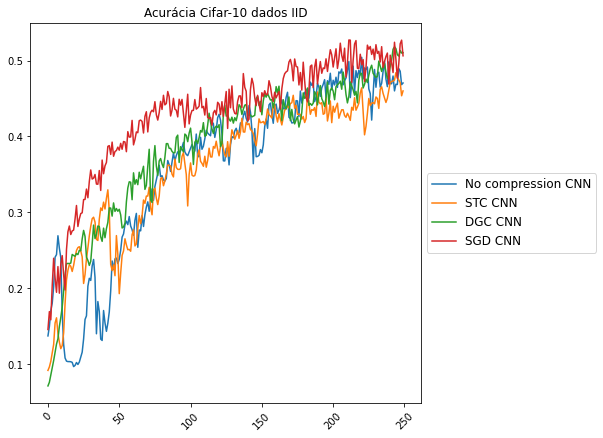

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
label = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
#None
none_cnn = [none_cif_acc_True]
none_cnn = none_cnn[0]
none_cnn = list(none_cnn)
none_log = [none_log_acc_True]
none_log = none_log[0]
none_log = list(none_log)
none_cnn_f = [none_cif_acc_False]
none_cnn_f = none_cnn_f[0]
none_cnn_f = list(none_cnn_f)
none_log_f = [none_log_acc_False]
none_log_f = none_log_f[0]
none_log_f = list(none_log_f)
#stc = [STC_cif_loss_True,STC_log_loss_True,STC_cif_loss_False, STC_log_loss_False]
stc_cnn = [STC_cif_acc_True]
stc_cnn = stc_cnn[0]
stc_cnn = list(stc_cnn)
stc_log = [STC_log_acc_True]
stc_log = stc_log[0]
stc_log = list(stc_log)
stc_cnn_f = [STC_cif_acc_False]
stc_cnn_f = stc_cnn_f[0]
stc_cnn_f = list(stc_cnn_f)
stc_log_f = [STC_log_acc_False]
stc_log_f = stc_log_f[0]
stc_log_f = list(stc_log_f)
#dgc = [dgc_cif_loss_True, dgc_log_loss_True,dgc_cif_loss_False,dgc_log_loss_False]
dgc_cnn = [dgc_cif_acc_True]
dgc_cnn = dgc_cnn[0]
dgc_cnn = list(dgc_cnn)
dgc_log = [dgc_log_acc_True]
dgc_log = dgc_log[0]
dgc_log = list(dgc_log)
dgc_cnn_f = [dgc_cif_acc_False]
dgc_cnn_f = dgc_cnn_f[0]
dgc_cnn_f = list(dgc_cnn_f)
dgc_log_f = [dgc_log_acc_False]
dgc_log_f = dgc_log_f[0]
dgc_log_f = list(dgc_log_f)
#sgd = [sgd_cif_loss_True, sgd_log_loss_True,sgd_cif_loss_False, sgd_log_loss_False]
sgd_cnn = [sgd_cif_acc_True]
sgd_cnn = sgd_cnn[0]
sgd_cnn = list(sgd_cnn)
sgd_log = [sgd_log_acc_True]
sgd_log = sgd_log[0]
sgd_log = list(sgd_log)
sgd_cnn_f = [sgd_cif_acc_False]
sgd_cnn_f = sgd_cnn_f[0]
sgd_cnn_f = list(sgd_cnn_f)
sgd_log_f = [sgd_log_acc_False]
sgd_log_f = sgd_log_f[0]
sgd_log_f = list(sgd_log_f)


df = pd.DataFrame({'No compression CNN IID': none_cnn,
                  'STC CNN IID': stc_cnn,
                  'DGC CNN IID':dgc_cnn,
                  'SGD CNN IID':sgd_cnn})
# Shrink current axis's height by 10% on the bottom
ax = df.plot.line(title='Acurácia Cifar-10 dados IID',rot=45,figsize = (7,7)).legend(ncol = 1,loc='center left', bbox_to_anchor=(1, 0.5),fontsize = 12)
#plt.yscale('log')


In [ ]:

,
                  

0

<function matplotlib.pyplot.show(close=None, block=None)>

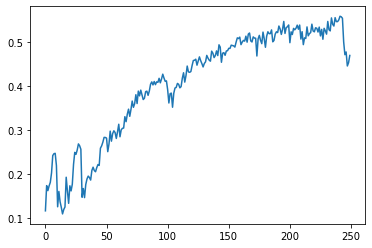

In [ ]:
plt.plot(none)
plt.show

In [ ]:
none = list(none)

In [ ]:
none = none[0]


In [ ]:
none

[0.1172,
 0.1744,
 0.163,
 0.1736,
 0.1818,
 0.2032,
 0.2426,
 0.2468,
 0.2476,
 0.22,
 0.1264,
 0.1612,
 0.1378,
 0.125,
 0.1102,
 0.1202,
 0.126,
 0.1934,
 0.162,
 0.1342,
 0.174,
 0.1624,
 0.1776,
 0.2226,
 0.2498,
 0.2454,
 0.255,
 0.269,
 0.2648,
 0.2568,
 0.148,
 0.1678,
 0.1472,
 0.1768,
 0.1894,
 0.196,
 0.1928,
 0.187,
 0.2088,
 0.2162,
 0.2086,
 0.2058,
 0.2152,
 0.2222,
 0.2202,
 0.2592,
 0.2646,
 0.273,
 0.2838,
 0.2836,
 0.2822,
 0.2514,
 0.2686,
 0.298,
 0.2752,
 0.2924,
 0.2988,
 0.2948,
 0.2814,
 0.2966,
 0.3136,
 0.2852,
 0.3008,
 0.3044,
 0.305,
 0.3308,
 0.3194,
 0.3366,
 0.3478,
 0.3316,
 0.3474,
 0.3662,
 0.352,
 0.3602,
 0.3806,
 0.3606,
 0.3888,
 0.378,
 0.391,
 0.3802,
 0.3696,
 0.3726,
 0.3876,
 0.3886,
 0.3792,
 0.389,
 0.4042,
 0.4096,
 0.4028,
 0.4106,
 0.4034,
 0.4098,
 0.4086,
 0.4178,
 0.4076,
 0.4164,
 0.4272,
 0.4184,
 0.411,
 0.412,
 0.392,
 0.3618,
 0.383,
 0.3842,
 0.3522,
 0.3838,
 0.3958,
 0.3972,
 0.4062,
 0.4042,
 0.3962,
 0.399,
 0.418,
 0.4304,